# Notebook for learning from data coursework 2022

In [3]:
# import our libraries that we will be using to investigate the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

total error squared:  371.50799578904713


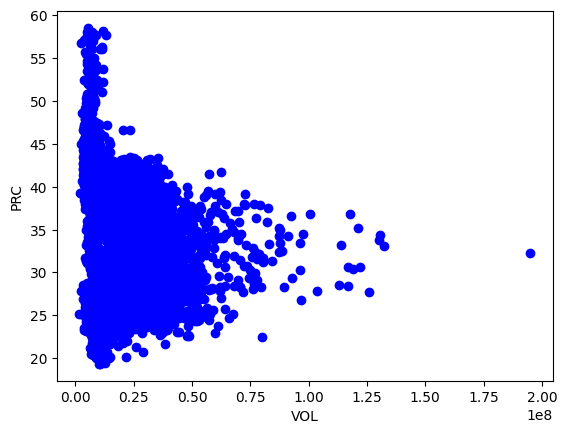

In [4]:
# load our data into a pandas dataframe

dataframe = pd.read_csv("AT_T_SBC_Stock_Price_Data_2000_2020.csv")

reg = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(dataframe[["OPENPRC", "VOL"]], dataframe["PRC"], test_size=0.3)

plt.plot(dataframe['VOL'], dataframe['PRC'], 'bo')
plt.xlabel("VOL")
plt.ylabel("PRC")

reg.fit(x_train, y_train)

predictions = reg.predict(x_test)
total_error = 0
for i in range(len(predictions)):
    total_error += pow(predictions[i] - y_test.array[i], 2)

print("total error squared: ", total_error)